In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [2]:
def fourier_sample(rng, n, p, n_freq = 20):
    x = jnp.linspace(0, 1, p)
    f = 0
    for i in range(n_freq):
        rng, key1, key2 = random.split(rng, 3)
        
        an = 1/(n_freq+1) * random.normal(key1, (n, 1))
        bn = 1/(n_freq+1) * random.normal(key2, (n, 1))

        f += an * jnp.cos(2*math.pi * i * x)[None,]
        f += bn * jnp.sin(2*math.pi * i * x)[None,]

    f += random.normal(rng, (n, 1))
    return f

In [ ]:
n, p = 500, 500
beta = random.normal(random.PRNGKey(0), (3,))
bias = 1
n_freq = 20

## train
rng = random.PRNGKey(0)
key1, key2 = random.split(rng)

xtrain = fourier_sample(key1, n, p, n_freq)
sigma = jnp.mean((xtrain)**2, axis = 1)[:,None]
epsilon = sigma * fourier_sample(key2, n, p, n_freq)
ytrain = bias + conv(xtrain, beta) + epsilon

xtrain = xtrain[:,None]
ytrain = ytrain[:,None]

## val
rng = random.PRNGKey(1)
key1, key2 = random.split(rng)

xval = fourier_sample(key1, n, p, n_freq)
sigma = jnp.mean((xval)**2, axis = 1)[:,None]
epsilon = sigma * fourier_sample(key2, n, p, n_freq)
yval = bias + conv(xval, beta) + epsilon

xval = xval[:,None]
yval = yval[:,None]

In [270]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [271]:
loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_fno = jnp.array(np.array(fno(jax2torch(xval)).squeeze()))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [4]:
def phi_tukey(z, x, w):
    f = jnp.sum(w[:,None] * (z > x), axis = 0)
    depth = 1 - jnp.abs(1 - 2 * f)
#     return jnp.min(depth)
    return 1/jnp.mean(1/depth)

# def phi_tukey(z, x, w):
#     mu = jnp.sum(w[:,None]*x, axis = 0)
#     sig = jnp.sqrt(jnp.sum((w[:,None]*x - mu)**2, axis = 0))
#     return jnp.mean(1/(1+jnp.sqrt((z - mu)**2/sig**2)))

phi_tukey = jit(phi_tukey)
v_phi_tukey = jit(vmap(phi_tukey, (0, None, None)))

def slice_phi(rng, p1, p2):
    phi = jax.random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi

def local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, rng):
    
    xtest_til = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
    dist = jnp.sqrt(jnp.mean((xval - xtest_til)**2, axis = (1, 2)))
    w = dist / jnp.sum(dist)
    
#     print(w.shape)
    
    n = xval.shape[0]
    alpha = 0.1
    quant = jnp.ceil((n+1)*(1-alpha))/n
    
    s = v_phi_tukey(rval_phi, rval_phi, w)
#     print(s.shape)
    q = jnp.quantile(s, 1 - quant)
#     q = jnp.flip(jnp.sort(s))[int(jnp.ceil((n+1)*(1-alpha)))]
    s_test = phi_tukey(rtest_phi, rval_phi, w)
    
    return s_test >= q

local_phi_inclusion = jit(vmap(local_phi_inclusion, (None, None, 0, 0, None)))

In [273]:
# nsim = 1
# cover_rand = np.zeros(nsim)
# cover_wave = np.zeros(nsim)
# cover_fpca = np.zeros(nsim)

# rng = random.PRNGKey(102391)
# phi = slice_phi(random.PRNGKey(0), p, 500)

# for i in trange(nsim):

#     ### test
#     rng, sub_rng = random.split(rng, 2)
#     key1, key2, key3 = random.split(sub_rng, 3)

#     xtest = fourier_sample(key1, n, p, n_freq)
#     sigma = jnp.mean((xtest)**2, axis = 1)[:,None]
#     epsilon = sigma * fourier_sample(key2, n, p, n_freq)
#     ytest = bias + conv(xtest, beta) + epsilon

#     xtest = xtest[:,None]
#     ytest = ytest[:,None]
#     with torch.no_grad():
#         ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))
    
#     ### residuals
#     rval_fno = yval.squeeze() - yval_fno
#     rtest_fno = ytest.squeeze() - ytest_fno
    
#     ## split again
#     keyR, keyW, keyF = random.split(key3, 3)
    
#     ### random basis
#     rval_phi = rval_fno @ phi
#     rtest_phi = rtest_fno @ phi

#     cover = np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, keyR))
#     cover_rand[i] = cover
    
# #     ### wavelet basis
# #     rval_phi = jwt.wavedec(rval_fno, 'haar', mode='zero', level=2)[0]
# #     rtest_phi = jwt.wavedec(rtest_fno, 'haar', mode='zero', level=2)[0]
# #     phi_weights = jnp.var(rval_phi, axis = 0) / np.max(jnp.var(rval_phi, axis = 0))

# #     cover = np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, keyW))
# #     cover_wave[i] = cover
    
# #     ### FPCA basis
# #     state = pcax.fit(rval_fno, n_components = 10)
# #     phi_weights = state[2] / jnp.max(state[2])

# #     rval_phi = pcax.transform(state, rval_fno)
# #     rtest_phi = pcax.transform(state, rtest_fno)

# #     cover = np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, keyF))
# #     cover_fpca[i] = cover

In [ ]:
def phi_tukey(z, x, w1, w2):
    f = jnp.sum(w1[:,None] * (z > x), axis = 0)
    depth = 1 - jnp.abs(1 - 2 * f)
    return jnp.min(depth)

phi_tukey = jit(phi_tukey)
v_phi_tukey = jit(vmap(phi_tukey, (0, None, None, None)))

In [486]:
rng = random.PRNGKey(2342)
phi = slice_phi(random.PRNGKey(0), p, 150)

### test
rng, sub_rng = random.split(rng, 2)
key1, key2, key3 = random.split(sub_rng, 3)

xtest = fourier_sample(key1, n, p, n_freq)
sigma = jnp.mean((xtest)**2, axis = 1)[:,None]
epsilon = sigma * fourier_sample(key2, n, p, n_freq)
ytest = bias + conv(xtest, beta) + epsilon

xtest = xtest[:,None]
ytest = ytest[:,None]
with torch.no_grad():
    ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))

rval_fno = yval.squeeze() - yval_fno
rtest_fno = ytest.squeeze() - ytest_fno

rval_phi = rval_fno @ phi
rtest_phi = rtest_fno @ phi

# phi_weights = 1

# state = pcax.fit(rval_fno, n_components = 40)
# phi_weights = state[2] / jnp.max(state[2])

# rval_phi = pcax.transform(state, rval_fno)
# rtest_phi = pcax.transform(state, rtest_fno)

# phi_weights = state[2] / jnp.sum(state[2])

# # rval_phi = rval_phi * phi_weights[None,]
# # rtest_phi = rtest_phi * phi_weights[None,]

# rval_phi = rval_phi / (state[2][None,])
# rtest_phi = rtest_phi / (state[2][None,])

In [487]:
# plt.plot(np.cumsum(phi_weights))

In [488]:
alpha = 0.1
nval = xval.shape[0]
cover = []
for i in trange(n):
    
    rng, sub_rng = random.split(rng, 2)

    z = rtest_phi[i]
    x = rval_phi

    xtest_til = xtest[i][None,] + 1e-2 * jax.random.normal(sub_rng, xtest[i][None,].shape)
    dist = jnp.sqrt(jnp.mean((xval - xtest_til)**2, axis = (1, 2)))
    w = dist / jnp.sum(dist)

    s = v_phi_tukey(x, x, w, phi_weights)
    q = jnp.flip(jnp.sort(s))[int(jnp.ceil((nval+1)*(1-alpha)))]

    s_test = phi_tukey(z, x, w, phi_weights)
    cover.append(s_test >= q)

  0%|          | 0/500 [00:00<?, ?it/s]

In [489]:
np.mean(cover)

0.926

In [490]:
jnp.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, sub_rng))

ValueError: vmap in_axes must be an int, None, or a tuple of entries corresponding to the positional arguments passed to the function, but got len(in_axes)=4, len(args)=3

In [13]:
def phi_depth1(z, x, w1, w2):
    f = jnp.sum(w1[:,None] * (z > x), axis = 0)
    depth = 1 - jnp.abs(1 - 2 * f)
    return jnp.min(depth)

def phi_depth2(z, x, w1, w2):
    f = jnp.sum(w1[:,None] * (z > x), axis = 0)
    depth = 1 - jnp.abs(1 - 2 * f)
    return 1/jnp.sum(w2/depth)
#     return np.sum(w2 * depth)

phi_depth1 = jit(phi_depth1)
phi_depth2 = jit(phi_depth2)
v_phi_depth1 = jit(vmap(phi_depth1, (0, None, None, None)))
v_phi_depth2 = jit(vmap(phi_depth2, (0, None, None, None)))

z = np.random.multivariate_normal(np.zeros(2), np.array([[1, 0.5],[0.5, 1]]), (5000,))
# w1 = jnp.ones(1)/5000
# w2 = jnp.ones(1)/2
# d1 = v_phi_depth1(z, z, w1, w2)
# d2 = v_phi_depth2(z, z, w1, w2)

phi = slice_phi(random.PRNGKey(0), 2, 50)
z_phi = z @ phi
d3 = v_phi_depth1(z_phi, z_phi, w1, w2)


state = pcax.fit(z, n_components = 2)
w4 = state[2] / jnp.sum(state[2])
z_pc = pcax.transform(state, z)
d4 = v_phi_depth1(z_pc, z_pc, w1, w2)

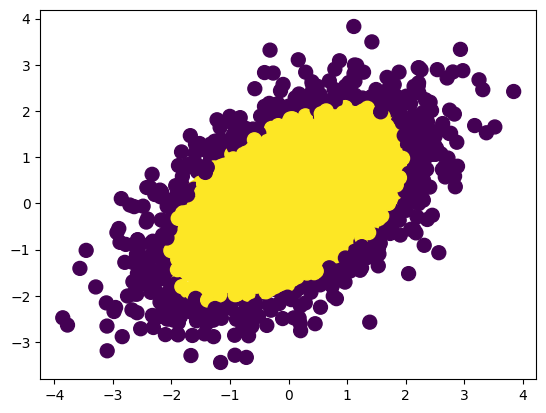

In [14]:
plt.scatter(z[:,0], z[:,1], c = d3 > 0.04, s = 100)
plt.show()

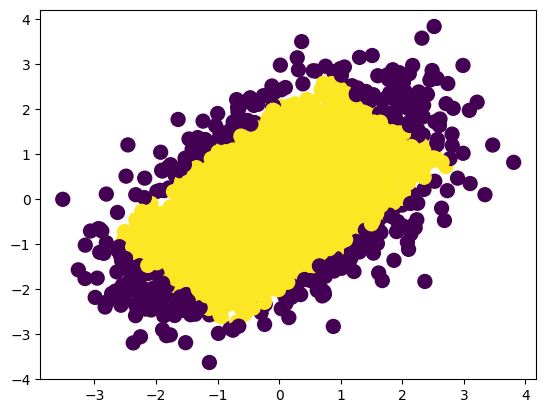

In [11]:
plt.scatter(z[:,0], z[:,1], c = d4 > 0.04, s = 100)
plt.show()

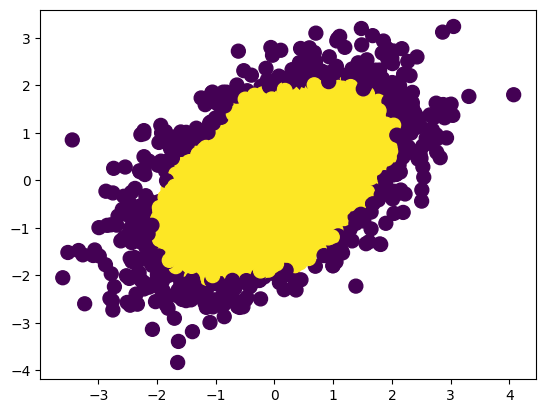

In [7]:
plt.scatter(z[:,0], z[:,1], c = d4 > 0.04, s = 100)
plt.show()

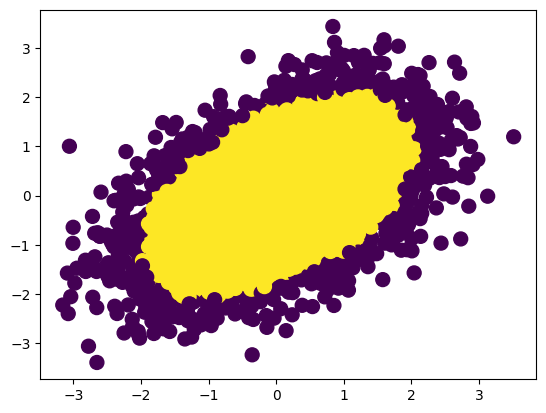

In [474]:
plt.scatter(z[:,0], z[:,1], c = d3 > 0.04, s = 100)
plt.show()

In [141]:
phi_tukey(rtest_phi[1], rval_phi, w)

Array(0.02763313, dtype=float32)

In [52]:
def phi_tukey(z, x, w):
    f = jnp.sum(w[:,None] * (z > x), axis = 0)
    depth = 1 - jnp.abs(1 - 2 * f)
    return jnp.mean(depth)

phi_tukey = jit(phi_tukey)
v_phi_tukey = jit(vmap(phi_tukey, (0, None, None)))

In [53]:
def local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, rng):
    
    xtest_til = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
    dist = jnp.sqrt(jnp.mean((xval - xtest_til)**2, axis = (1, 2)))
    w = dist / jnp.sum(dist)
    
    n = xval.shape[0]
    alpha = 0.1
    quant = jnp.ceil((n + 1) * (1 - alpha)) / n
    
    s = v_phi_tukey(rval_phi, rval_phi, w)
    q = jnp.quantile(s, 1 - quant)
#     q = jnp.flip(jnp.sort(s))[int(jnp.ceil((n+1)*(1-alpha)))]
    s_test = phi_tukey(rtest_phi, rval_phi, w)
    
    return s_test >= q*0.95

local_phi_inclusion = jit(local_phi_inclusion)
# local_phi_inclusion = vmap(local_phi_inclusion, (None, None, 0, 0, None))

In [54]:
cover = [local_phi_inclusion(rval_phi, xval, rtest_phi[i], xtest[i], keyR) for i in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.mean(local_phi_inclusion(rval_phi, xval, rtest_phi, xtest, keyR))

In [8]:
# phi_weights.shape

0.0 0.0 0.0


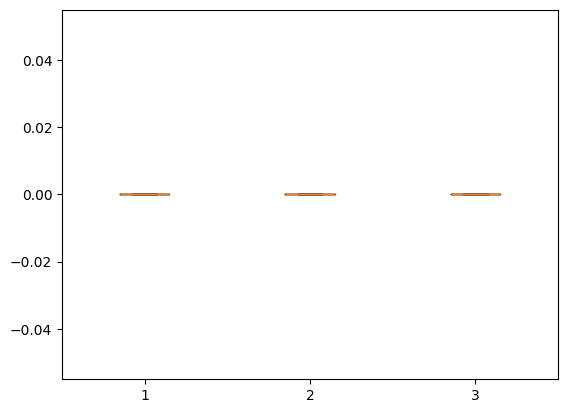

In [9]:
plt.boxplot([cover_rand, cover_wave, cover_fpca])
print(np.round(np.mean(cover_rand), 3), np.round(np.mean(cover_wave), 3), np.round(np.mean(cover_fpca), 3))
plt.show()